In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional

# --- Constants (SI) ---
kB = 1.380649e-23          # J/K
NA = 6.02214076e23         # 1/mol
from physkit.constants import ConstantsSI

@dataclass(frozen=True)
class ConstantsCGS:
  N_A = ConstantsSI.N_A

@dataclass(frozen=True)
class Species:
    """
    Physical species metadata for Hertz–Knudsen modeling.
    """
    name: str
    molar_mass: float #g/mol
    density: float    #g/cm^3 (solid film density, for thickness rate)

    @property
    def m_kg(self) -> float:
        """Molecular/atomic mass in kg."""
        return self.molar_mass_kg_per_mol / NA

In [4]:
@dataclass(frozen=True)
class ClausiusClapeyronLogP:
    """
    Simple vapor pressure model:
      ln p_sat(T) = A - B/T

    p_sat in Pa, T in K.
    B ~ ΔH_sub / R (if derived from Clausius–Clapeyron with constant enthalpy).
    """
    A: float
    B_K: float

    def p_saturation_Pa(self, T_K: np.ndarray) -> np.ndarray:
        T_K = np.asarray(T_K, dtype=float)
        return np.exp(self.A - self.B_K / T_K)


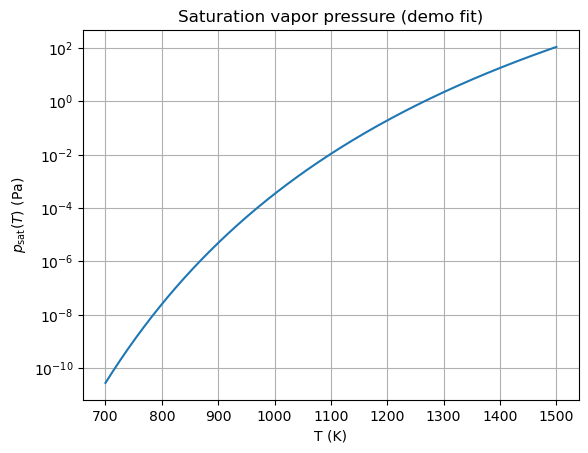

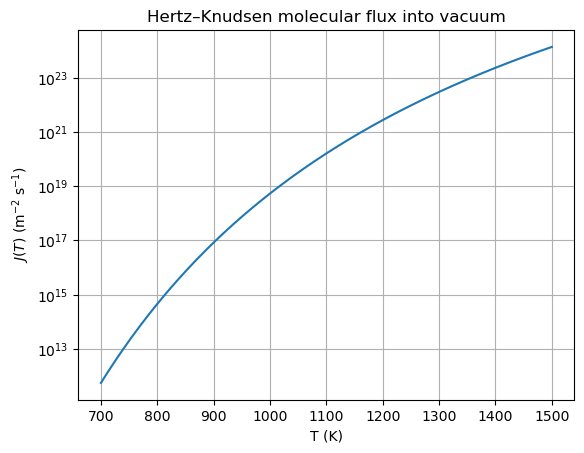

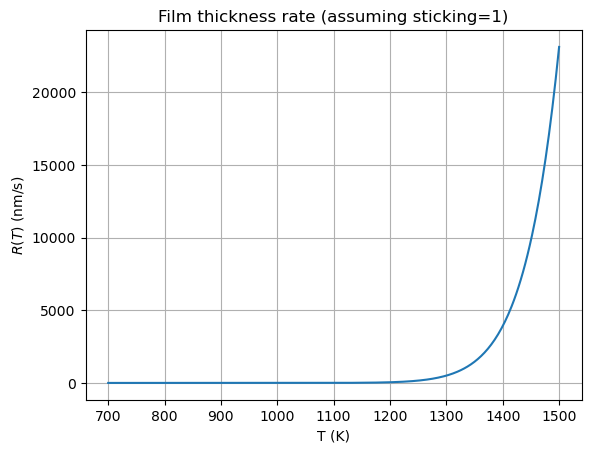

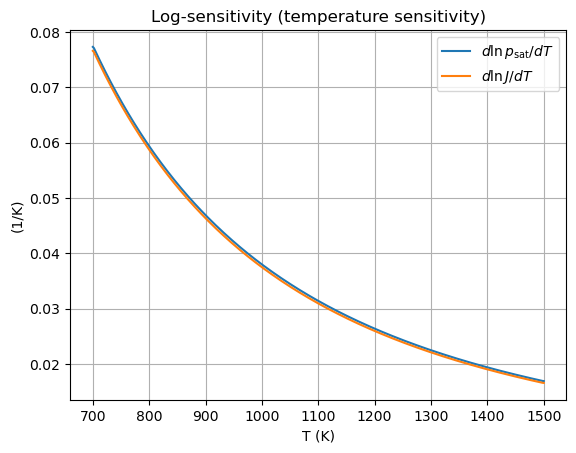

Demo summary (at endpoints):
T_min=700.0 K: psat=2.837e-11 Pa, J=5.439e+11 1/(m^2 s), R=9.025e-09 nm/s
T_max=1500.0 K: psat=1.063e+02 Pa, J=1.393e+24 1/(m^2 s), R=2.311e+04 nm/s


In [5]:
@dataclass(frozen=True)
class Species:
    """
    Physical species metadata for Hertz–Knudsen modeling.
    """
    name: str
    molar_mass_kg_per_mol: float   # kg/mol
    density_kg_per_m3: float       # kg/m^3 (solid film density, for thickness rate)

    @property
    def m_kg(self) -> float:
        """Molecular/atomic mass in kg."""
        return self.molar_mass_kg_per_mol / NA

@dataclass(frozen=True)
class ClausiusClapeyronLogP:
    """
    Simple vapor pressure model:
      ln p_sat(T) = A - B/T

    p_sat in Pa, T in K.
    B ~ ΔH_sub / R (if derived from Clausius–Clapeyron with constant enthalpy).
    """
    A: float
    B_K: float

    def psat_Pa(self, T_K: np.ndarray) -> np.ndarray:
        T_K = np.asarray(T_K, dtype=float)
        return np.exp(self.A - self.B_K / T_K)

def hertz_knudsen_flux(
    T_K: np.ndarray,
    psat_Pa: np.ndarray,
    *,
    species: Species,
    p_Pa: float = 0.0,
    alpha_evap: float = 1.0,
    alpha_cond: float = 1.0,
) -> np.ndarray:
  """
  Net molecular flux (m^-2 s^-1):
    J = alpha_evap * psat / sqrt(2*pi*m*kB*T) - alpha_cond * p / sqrt(2*pi*m*kB*T)
  """
  T_K = np.asarray(T_K, dtype=float)
  psat_Pa = np.asarray(psat_Pa, dtype=float)
  denom = np.sqrt(2.0 * np.pi * species.m_kg * kB * T_K)
  return (alpha_evap * psat_Pa - alpha_cond * p_Pa) / denom

def thickness_rate_m_per_s(
    J_m2_s: np.ndarray,
    *,
    species: Species,
    sticking: float = 1.0,
) -> np.ndarray:
    """
    Film thickness rate (m/s) assuming all arriving mass contributes to film:
      R = (sticking * m * J) / rho
    """
    return sticking * species.m_kg * np.asarray(J_m2_s, dtype=float) / species.density_kg_per_m3

def log_sensitivity_numeric(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Numeric d(ln y)/dx using centered differences, with endpoint one-sided.
    """
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    ln_y = np.log(np.maximum(y, np.finfo(float).tiny))
    dln = np.gradient(ln_y, x)
    return dln

# -----------------------------
# Example setup (ALUMINUM demo values)
# NOTE: The Clausius–Clapeyron parameters below are placeholders for teaching/demo.
# Replace (A, B) with a fit to trusted vapor-pressure data for your material.
# -----------------------------
Al = Species(
    name="Al",
    molar_mass_kg_per_mol=26.9815385e-3,
    density_kg_per_m3=2700.0
)

# Placeholder vapor-pressure fit (DEMO ONLY)
vp = ClausiusClapeyronLogP(A=30.0, B_K=38000.0)

# Temperature sweep
T = np.linspace(700.0, 1500.0, 400)

# Model pipeline
psat = vp.psat_Pa(T)
J = hertz_knudsen_flux(T, psat, species=Al, p_Pa=0.0, alpha_evap=1.0, alpha_cond=1.0)
R = thickness_rate_m_per_s(J, species=Al, sticking=1.0)

# Sensitivity
dlnJ_dT = log_sensitivity_numeric(J, T)
dlnpsat_dT = log_sensitivity_numeric(psat, T)

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.semilogy(T, psat)
plt.xlabel("T (K)")
plt.ylabel(r"$p_{\mathrm{sat}}(T)$ (Pa)")
plt.title("Saturation vapor pressure (demo fit)")
plt.grid(True)

plt.figure()
plt.semilogy(T, J)
plt.xlabel("T (K)")
plt.ylabel(r"$J(T)$ (m$^{-2}$ s$^{-1}$)")
plt.title("Hertz–Knudsen molecular flux into vacuum")
plt.grid(True)

plt.figure()
plt.plot(T, R * 1e9)
plt.xlabel("T (K)")
plt.ylabel(r"$R(T)$ (nm/s)")
plt.title("Film thickness rate (assuming sticking=1)")
plt.grid(True)

plt.figure()
plt.plot(T, dlnpsat_dT, label=r"$d\ln p_{\mathrm{sat}}/dT$")
plt.plot(T, dlnJ_dT, label=r"$d\ln J/dT$")
plt.xlabel("T (K)")
plt.ylabel(r"(1/K)")
plt.title("Log-sensitivity (temperature sensitivity)")
plt.grid(True)
plt.legend()

plt.show()

print("Demo summary (at endpoints):")
print(f"T_min={T[0]:.1f} K: psat={psat[0]:.3e} Pa, J={J[0]:.3e} 1/(m^2 s), R={R[0]*1e9:.3e} nm/s")
print(f"T_max={T[-1]:.1f} K: psat={psat[-1]:.3e} Pa, J={J[-1]:.3e} 1/(m^2 s), R={R[-1]*1e9:.3e} nm/s")
